# <b>1 <span style='color:#4285f4'>|</span> Importing libraries</b>
- **For ML Models**: Tensorflow, keras
- **For Data Manipulation**: numpy, pandas, sklearn
- **For Data Visualization**: matplotlib, seaborn

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

C:\Users\Badr_\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [8]:
train_dir = './original-data/Training/'
test_dir = './original-data/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

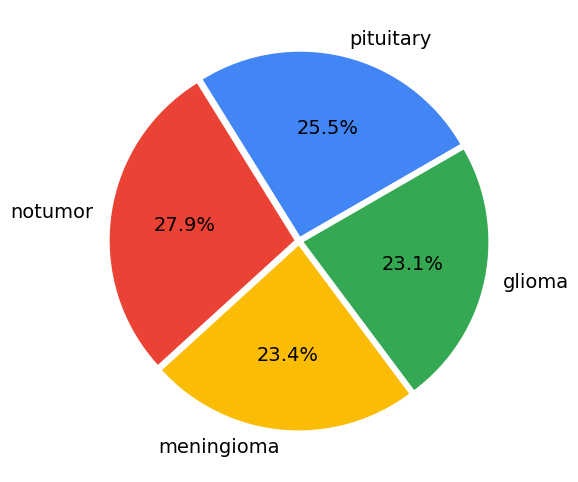

In [9]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

#### The dataset is reasonably balanced

In [10]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# <b>3 <span style='color:#4285f4'>|</span> Data Augmentation</b>
- Random Brightness: 80% - 120%  
- Random Contrast: 80% - 120%


In [ ]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;">Let's plot some Samples :</h3>

In [ ]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

# <b>4 <span style='color:#4285f4'>|</span> Data Generator</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [ ]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b>5 <span style='color:#4285f4'>|</span> Model</b>

### I am using **VGG16** for transfer learning

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# <b>6 <span style='color:#4285f4'>|</span> Train Model</b>

In [ ]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 4
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# <b>7 <span style='color:#4285f4'>|</span> Evaluate Model with Test Samples</b>

In [ ]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))

### Please Upvote this notebook as it encourages me in doing better.


![](http://68.media.tumblr.com/e1aed171ded2bd78cc8dc0e73b594eaf/tumblr_o17frv0cdu1u9u459o1_500.gif)